**Import packages**

In [197]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
from keras import regularizers
import cv2
import matplotlib.pyplot as plt
import glob
from keras.layers import *
from keras.models import *
import matplotlib.image as mpimg
import random

**Plotting one image from each class :**

In [198]:
train_dir = 'asl_alphabet_train'
val_dir = 'asl_alphabet_val'
IMG_SIZE = 64, 64

unique_labels =  ['I', 'C', 'X', 'K', 'Q', 'U', 'N', 'nothing', 'F', 'H', 'del', 'J', 'Y', 'G', 'Z', 'L', 'W', 'O', 'T', 'S', 'D', 'space', 'P', 'B', 'E', 'R', 'V', 'M', 'A']


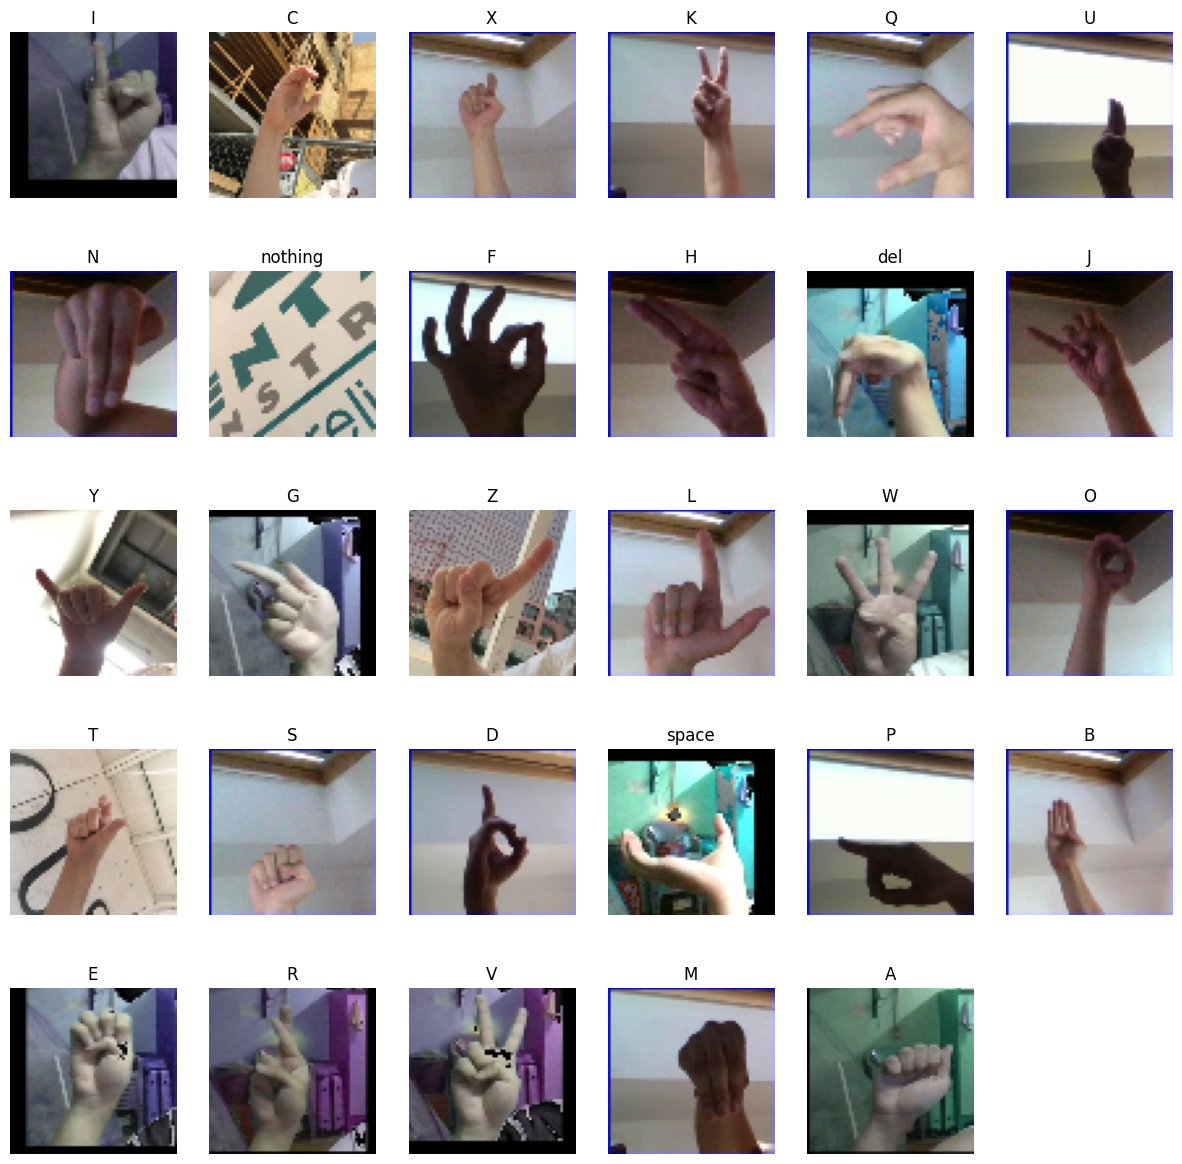

In [199]:
def load_unique():
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, IMG_SIZE)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

**Load data**

In [200]:

train_data = tf.keras.preprocessing.image_dataset_from_directory(   
    directory='asl_alphabet_train',
    label_mode="categorical",
    image_size=(200,200),
    seed=40,
    batch_size=256,
    validation_split=0.2,
    subset='training'
)

val_data = tf.keras.preprocessing.image_dataset_from_directory( 
    directory='asl_alphabet_train',
    label_mode="categorical",
    image_size=(200,200),
    seed=40,
    validation_split=0.2,
    batch_size=256,
    subset='validation',
    interpolation="bilinear"
)

Found 11165 files belonging to 29 classes.
Using 8932 files for training.
Found 11165 files belonging to 29 classes.
Using 2233 files for validation.


**Data Augmentation**

In [201]:
from tensorflow.keras.layers import RandomBrightness, RandomContrast,GaussianNoise

data_augmentation = Sequential([
    RandomBrightness([-0.8,0.8]),
    RandomContrast(0.2),
    GaussianNoise(1)
], name ="data_augmentation")


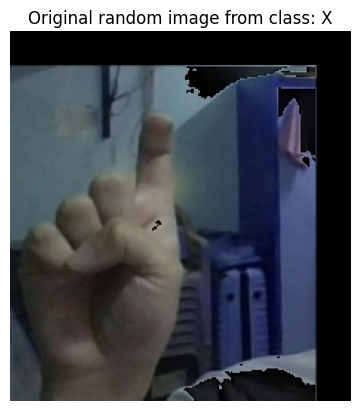

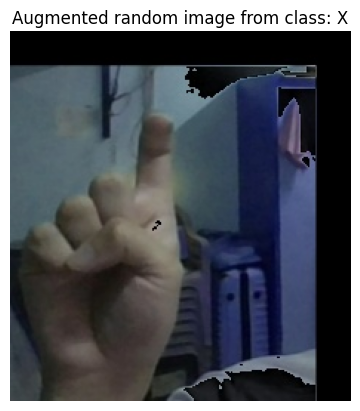

In [202]:
# Xem ảnh ngẫu nhiên

target_class = random.choice(train_data.class_names) # chọn một class ngẫu nhiên
target_dir = train_dir + '/' + target_class # tạo directory đích
random_image = random.choice(os.listdir(target_dir)) # chọn một ảnh ngẫu nhiên từ directory đích
random_image_path = target_dir + "/" + random_image # tạo đường dẫn ảnh ngẫu nhiên đã chọn 
img = mpimg.imread(random_image_path) # đọc trong ảnh mục tiêu đã chọn
plt.imshow(img) # vẽ ảnh mục tiêu
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn-off các trục 

# Tăng cường ảnh
augmented_img = RandomFlip("horizontal")(tf.expand_dims(img, axis=0)) # mô hình data augmentation yêu cầu shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # yêu cầu chuẩn hóa sau khi tăng cường
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

**Create model**

In [203]:
input_shape = (200, 200, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Tạo layer đầu vào
inputs = Input(shape=input_shape, name="input_layer")

# Thêm vào mô hình tuần tự tăng cường dữ liệu dưới dạng layer
x = data_augmentation(inputs)

# Cung cấp đầu vào cho base_model (sau khi tăng cường) và không huấn luyện nó 
x = base_model(x, training=False)

# Gộp các đặc trưng đầu ra của base model
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

x = Dense(256)(x)
x = Dropout(rate=.4)(x)  

outputs = Dense(29, activation="softmax", name="output_layer")(x)

# Tạo mô hình với đầu vào và đầu ra
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 200, 200, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                           

In [204]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15, verbose=1)

filepath="best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

def lr_schedule(epoch):
    """
    Hàm callback trả về learning rate mới cho mỗi epoch
    """
    lr = .005
    if epoch > 4:
        lr = .003
    if epoch > 8:
        lr = .001
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks_list = [early_stopping, checkpoint, lr_scheduler]

In [205]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy', metrics=['accuracy'])

In [206]:
model_hist = model.fit(train_data,validation_data = val_data, epochs = 60, callbacks=callbacks_list)

Epoch 1/60
35/35 [==============================] - ETA: 0s - loss: 2.5492 - accuracy: 0.5366
Epoch 1: val_accuracy improved from -inf to 0.82132, saving model to best_model.h5
35/35 [==============================] - 65s 2s/step - loss: 2.5492 - accuracy: 0.5366 - val_loss: 0.7238 - val_accuracy: 0.8213 - lr: 0.0050
Epoch 2/60
35/35 [==============================] - ETA: 0s - loss: 1.2440 - accuracy: 0.7157
Epoch 2: val_accuracy improved from 0.82132 to 0.88983, saving model to best_model.h5
35/35 [==============================] - 61s 2s/step - loss: 1.2440 - accuracy: 0.7157 - val_loss: 0.5426 - val_accuracy: 0.8898 - lr: 0.0050
Epoch 3/60
35/35 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.7511
Epoch 3: val_accuracy improved from 0.88983 to 0.91178, saving model to best_model.h5
35/35 [==============================] - 61s 2s/step - loss: 0.9925 - accuracy: 0.7511 - val_loss: 0.4098 - val_accuracy: 0.9118 - lr: 0.0050
Epoch 4/60
35/35 [===================

In [207]:
model.save('model.h5')

**Plotting the model performance metrics to check model performance.**

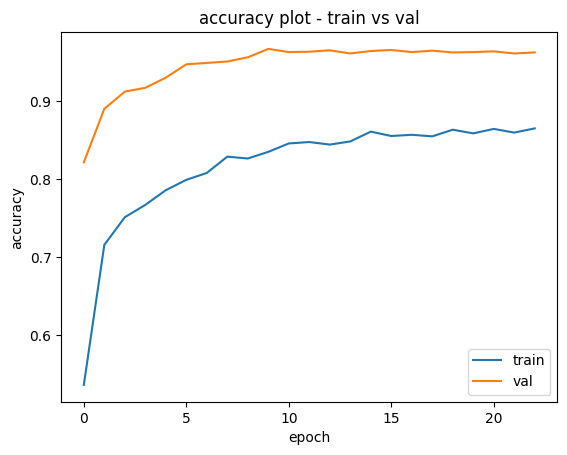

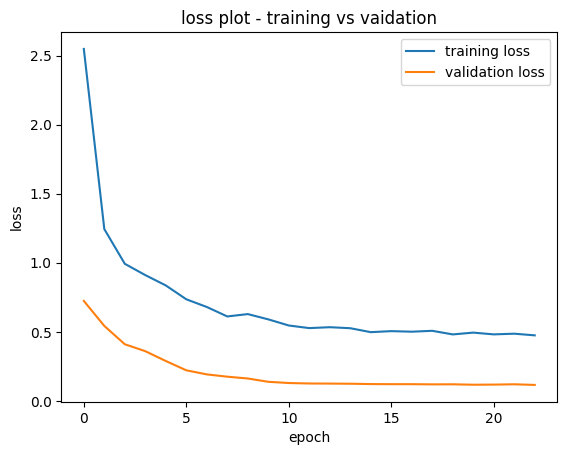

In [208]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.legend(['train', 'val'], loc='lower right')
plt.title('accuracy plot - train vs val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

**EVALUATING THE TRAINED MODEL ON THE VALIDATION DATA SPLIT**

In [209]:
model = keras.models.load_model('best_model.h5')

In [210]:
evaluate_metrics = model.evaluate(val_data)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

9/9 [==============================] - 3s 236ms/step - loss: 0.1378 - accuracy: 0.9664

Evaluation Accuracy =  96.64% 
Evaluation loss =  0.137817


In [211]:
labels = []
predicts = []
for image, label in val_data.unbatch():
    predict = np.argmax(np.squeeze(model.predict(image.numpy().reshape(1,200,200,3))))
    predicts.append(predict)
    labels.append(np.argmax(label))

predicts = np.array(predicts)
labels = np.array(labels)

1/1 [==============================] - 0s 14ms/step


Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

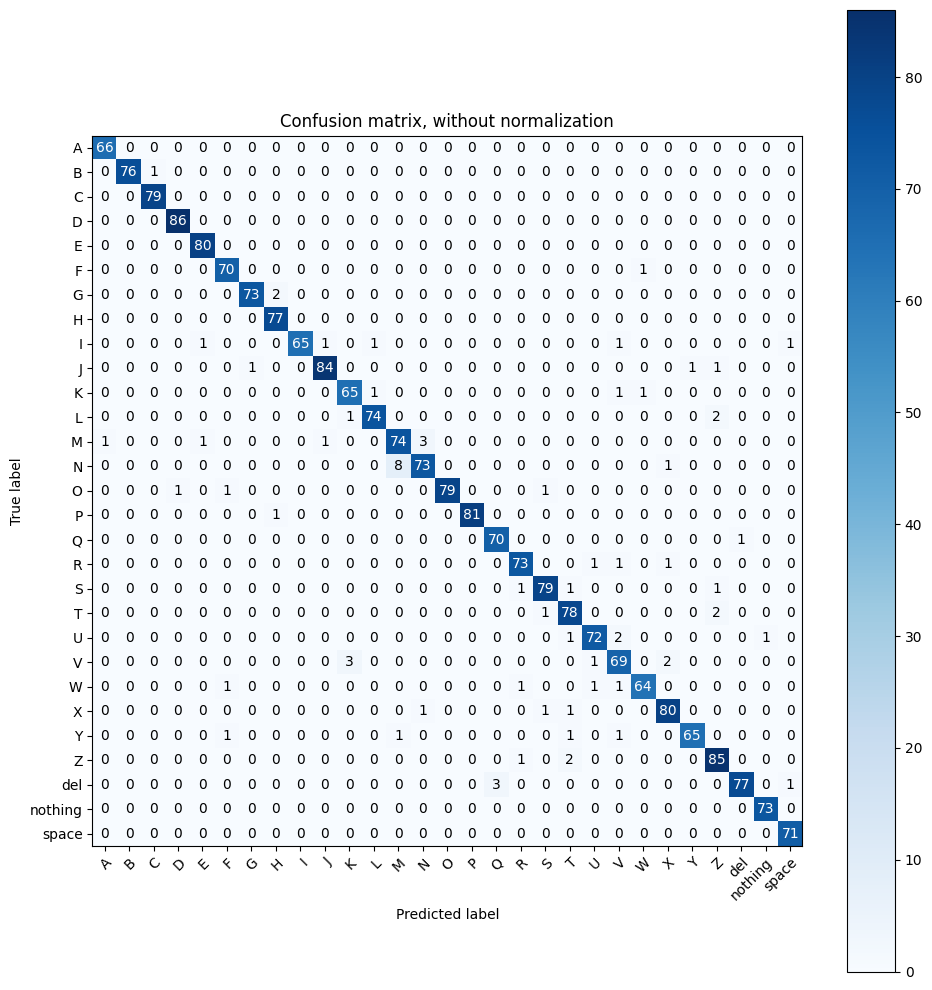

In [212]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(labels, predicts)
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(labels, predicts, classes = train_data.class_names)
plt.show()

In [213]:
from sklearn.metrics import classification_report
print(classification_report(labels, predicts))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        66
           1       1.00      0.99      0.99        77
           2       0.99      1.00      0.99        79
           3       0.99      1.00      0.99        86
           4       0.98      1.00      0.99        80
           5       0.96      0.99      0.97        71
           6       0.99      0.97      0.98        75
           7       0.96      1.00      0.98        77
           8       1.00      0.93      0.96        70
           9       0.98      0.97      0.97        87
          10       0.94      0.96      0.95        68
          11       0.97      0.96      0.97        77
          12       0.89      0.93      0.91        80
          13       0.95      0.89      0.92        82
          14       1.00      0.96      0.98        82
          15       1.00      0.99      0.99        82
          16       0.96      0.99      0.97        71
          17       0.96    